<a href="https://colab.research.google.com/github/sunghyouk/study_room/blob/master/self_ML_DL_study_text/ch7_3_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# fashione MNIST 불러오기
from tensorflow import keras
(train_input, train_target), (test_input, test_target) = \
keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [2]:
from sklearn.model_selection import train_test_split
train_scaled = train_input / 255.0 # regularization
# train_scaled = train_scaled.reshape(-1, 28*28) # 가로, 세로 2차원을 1차원으로 만들기: flatten으로 쉽게 가능
train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

In [3]:
def model_fn(a_layer=None):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    model.add(keras.layers.Dense(100, activation='relu'))
    if a_layer:
        model.add(a_layer)
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [4]:
model = model_fn()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [5]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=5, verbose=0)

In [6]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


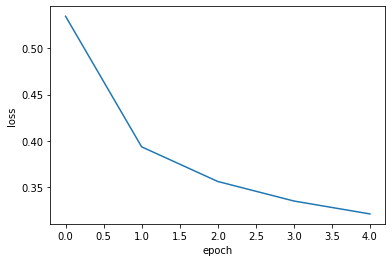

In [7]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

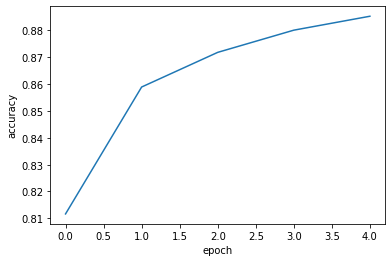

In [8]:
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

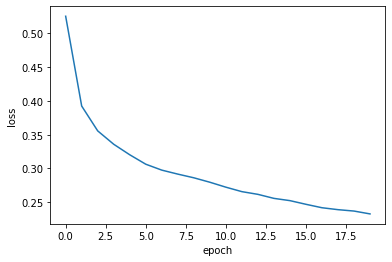

In [9]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0)
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## overfit 문제
test set 뿐만 아니라 validation set의 손실 함수 최적화가 어떻게 되어 가는지도 같이 고려해야 한다.

In [10]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target))

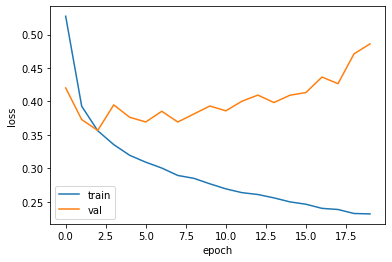

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

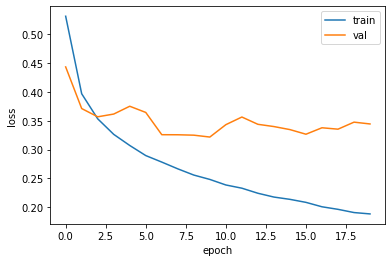

In [12]:
model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## Dropout
훈련 과정에서 층에 있는 일부 뉴런을 랜덤하게 꺼서 과대적합을 막는 기법

In [13]:
model = model_fn(keras.layers.Dropout(0.3))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_9 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


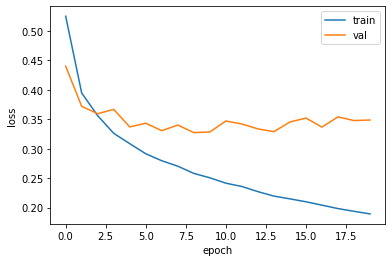

In [14]:
model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## 모델의 저장과 복원
save_weights(): 훈련된 모델의 파라미터 저장  
save(): 모델 구조와 모델 파라미터를 함께 저장

In [15]:
model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=10, verbose=0,
                    validation_data=(val_scaled, val_target))

In [16]:
model.save_weights('model-weights.h5')
model.save('model-whole.h5')

In [17]:
!ls -al *.h5

-rw-r--r-- 1 root root 332656 Nov 17 12:00 model-weights.h5
-rw-r--r-- 1 root root 981824 Nov 17 12:00 model-whole.h5


In [18]:
# 새 모델을 만들고 model-weights.h5 파일에서 훈련된 모델 파라미터를 읽어서 사용
model = model_fn(keras.layers.Dropout(0.3))
model.load_weights('model-weights.h5')

In [19]:
import numpy as np
val_labels = np.argmax(model.predict(val_scaled), axis=-1)
print(np.mean(val_labels == val_target))

0.8889166666666667


In [20]:
# model_whole.h5 파일에서 새로운 모델을 만들어 바로 사용
model = keras.models.load_model('model-whole.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 1ms/step - loss: 0.3196 - accuracy: 0.8889


[0.3196035325527191, 0.8889166712760925]

## callback
훈련 과정 중간에 어떤 작업을 수행할 수 있게 하는 객체

In [21]:
# ModelCheckpoint: 최상의 검증 점수를 만드는 모델을 저장
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5')
model.fit(train_scaled, train_target, epochs=20, verbose=0,
          validation_data=(val_scaled, val_target),
          callbacks=[checkpoint_cb])

In [23]:
model = keras.models.load_model('best-model.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3278 - accuracy: 0.8868


[0.3278030455112457, 0.8868333101272583]

In [25]:
# EarlyStopping: 과대적합이 시작되기 전에 훈련을 미리 중지
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)
history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

In [26]:
# 몇 번째 epoch에서 멈췄는지 확인
print(early_stopping_cb.stopped_epoch)

9


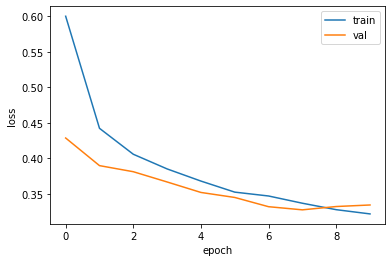

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [28]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3277 - accuracy: 0.8802


[0.32767197489738464, 0.8801666498184204]